In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import itertools
import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv', parse_dates=['date'])
test = pd.read_csv('test.csv', parse_dates=['date'])
data = pd.concat([train, test], sort=False)
data.head()

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN


In [3]:
train.store.nunique(), test.store.nunique(), train.item.nunique(), test.item.nunique()

(10, 10, 18, 50)

In [4]:
data.shape

(371871, 5)

In [5]:
data.quantile([0, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 1]).T

,0.00,0.05,0.25,0.50,0.75,0.95,0.99,1.00
store,1.0,1.00,3.00,5.0,8.00,10.00,10.00,10.0
item,1.0,1.00,5.00,10.0,15.00,30.00,46.00,50.0
sales,0.0,15.00,30.00,51.0,74.00,111.00,138.00,231.0
id,0.0,2249.95,11249.75,22499.5,33749.25,42749.05,44549.01,44999.0


In [6]:
train["date"].min(), train["date"].max(), test["date"].min(), test["date"].max()

(Timestamp('2013-01-01 00:00:00'),
 Timestamp('2017-12-31 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2018-03-31 00:00:00'))

In [7]:
data["date"].min()

Timestamp('2013-01-01 00:00:00')

In [8]:
data["date"].max()

Timestamp('2018-03-31 00:00:00')

In [9]:
data.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [10]:
data.groupby(["store"]).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})

sales                                                    
       count        sum       mean median        std  min    max
store                                                           
1      32868  1636396.0  49.786905   48.0  25.462343  3.0  155.0
2      32868  2317314.0  70.503651   68.0  35.674123  3.0  231.0
3      32868  2058829.0  62.639315   61.0  31.819851  3.0  196.0
4      32868  1899717.0  57.798375   56.0  29.422393  4.0  180.0
5      32868  1374617.0  41.822350   40.0  21.579829  2.0  130.0
6      32868  1373405.0  41.785475   40.0  21.505169  0.0  129.0
7      32868  1257516.0  38.259584   37.0  19.787294  1.0  122.0
8      32868  2217653.0  67.471492   66.0  34.222704  4.0  200.0
9      32868  1902394.0  57.879822   56.0  29.503920  4.0  187.0
10     31059  1856823.0  59.783734   57.0  30.594567  3.0  183.0

In [11]:
data.groupby(["item"]).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})

sales                                                     
      count        sum       mean median        std   min    max
item                                                            
1     18260   401384.0  21.981599   21.0   8.468922   1.0   59.0
2     18260  1069564.0  58.574151   56.0  20.093015   9.0  150.0
3     18260   669087.0  36.642223   35.0  13.179441   7.0  104.0
4     18260   401907.0  22.010241   21.0   8.403898   0.0   66.0
5     18260   335230.0  18.358708   18.0   7.265167   1.0   50.0
6     18260  1068281.0  58.503888   56.0  20.174898  11.0  148.0
7     18260  1068777.0  58.531051   56.0  20.146002  11.0  141.0
8     18260  1405108.0  76.950055   74.0  26.130697  15.0  181.0
9     18260   938379.0  51.389869   49.5  17.790158   6.0  134.0
10    18260  1337133.0  73.227437   70.0  24.823725  14.0  175.0
11    18260  1271925.0  69.656353   67.0  23.744732  11.0  170.0
12    18260  1271534.0  69.634940   67.0  23.738663  12.0  170.0
13    18260  1539621.0  84.316594   81.0  28.311031  20.0  210.0
14    18260  1071531.0  58.681873   56.0  20.079860  12.0  152.0
15    18260  1607442.0  88.030778   85.0  29.522852  17.0  231.0
16    18260   468480.0  25.656079   25.0   9.603270   2.0   70.0
17    18260   602486.0  32.994852   32.0  11.967610   4.0   83.0
18    16451  1366795.0  83.082791   79.0  28.567588  18.0  208.0
19        0        0.0        NaN    NaN        NaN   NaN    NaN
20        0        0.0        NaN    NaN        NaN   NaN    NaN
21        0        0.0        NaN    NaN        NaN   NaN    NaN
22        0        0.0        NaN    NaN        NaN   NaN    NaN
23        0        0.0        NaN    NaN        NaN   NaN    NaN
24        0        0.0        NaN    NaN        NaN   NaN    NaN
25        0        0.0        NaN    NaN        NaN   NaN    NaN
26        0        0.0        NaN    NaN        NaN   NaN    NaN
27        0        0.0        NaN    NaN        NaN   NaN    NaN
28        0        0.0        NaN    NaN        NaN   NaN    NaN
29        0        0.0        NaN    NaN        NaN   NaN    NaN
30        0        0.0        NaN    NaN        NaN   NaN    NaN
31        0        0.0        NaN    NaN        NaN   NaN    NaN
32        0        0.0        NaN    NaN        NaN   NaN    NaN
33        0        0.0        NaN    NaN        NaN   NaN    NaN
34        0        0.0        NaN    NaN        NaN   NaN    NaN
35        0        0.0        NaN    NaN        NaN   NaN    NaN
36        0        0.0        NaN    NaN        NaN   NaN    NaN
37        0        0.0        NaN    NaN        NaN   NaN    NaN
38        0        0.0        NaN    NaN        NaN   NaN    NaN
39        0        0.0        NaN    NaN        NaN   NaN    NaN
40        0        0.0        NaN    NaN        NaN   NaN    NaN
41        0        0.0        NaN    NaN        NaN   NaN    NaN
42        0        0.0        NaN    NaN        NaN   NaN    NaN
43        0        0.0        NaN    NaN        NaN   NaN    NaN
44        0        0.0        NaN    NaN        NaN   NaN    NaN
45        0        0.0        NaN    NaN        NaN   NaN    NaN
46        0        0.0        NaN    NaN        NaN   NaN    NaN
47        0        0.0        NaN    NaN        NaN   NaN    NaN
48        0        0.0        NaN    NaN        NaN   NaN    NaN
49        0        0.0        NaN    NaN        NaN   NaN    NaN
50        0        0.0        NaN    NaN        NaN   NaN    NaN

In [12]:
data["store"].nunique()

10

In [13]:
data["item"].nunique()

50

In [14]:
data['month'] = data.date.dt.month
data['day_of_month'] = data.date.dt.day
data['day_of_year'] = data.date.dt.dayofyear
data['week_of_year'] = data.date.dt.weekofyear
data['day_of_week'] = data.date.dt.dayofweek
data['year'] = data.date.dt.year
data["is_wknd"] = data.date.dt.weekday // 4
data['is_month_start'] = data.date.dt.is_month_start.astype(int)
data['is_month_end'] = data.date.dt.is_month_end.astype(int)

In [15]:
data.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0


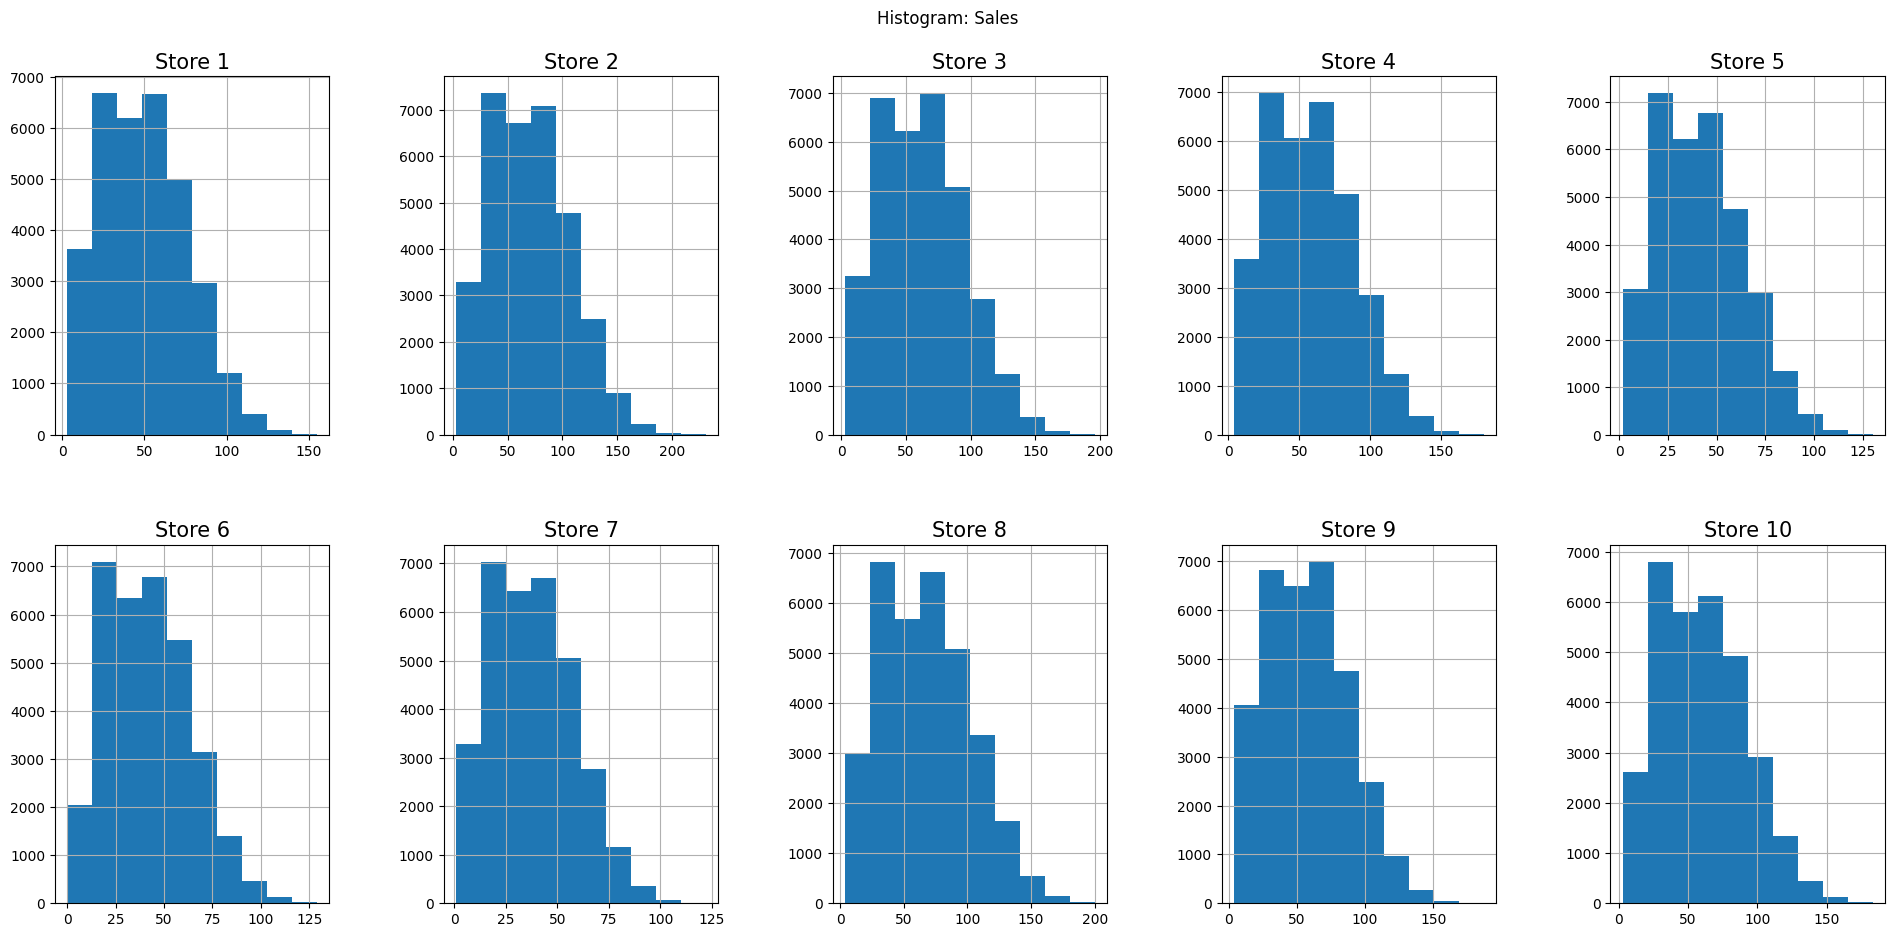

In [16]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for i in range(1,11):
    if i < 6:
        train[train.store == i].sales.hist(ax=axes[0, i-1])
        axes[0,i-1].set_title("Store " + str(i), fontsize = 15)
        
    else:
        train[train.store == i].sales.hist(ax=axes[1, i - 6])
        axes[1,i-6].set_title("Store " + str(i), fontsize = 15)
plt.tight_layout(pad=4.5)
plt.suptitle("Histogram: Sales");

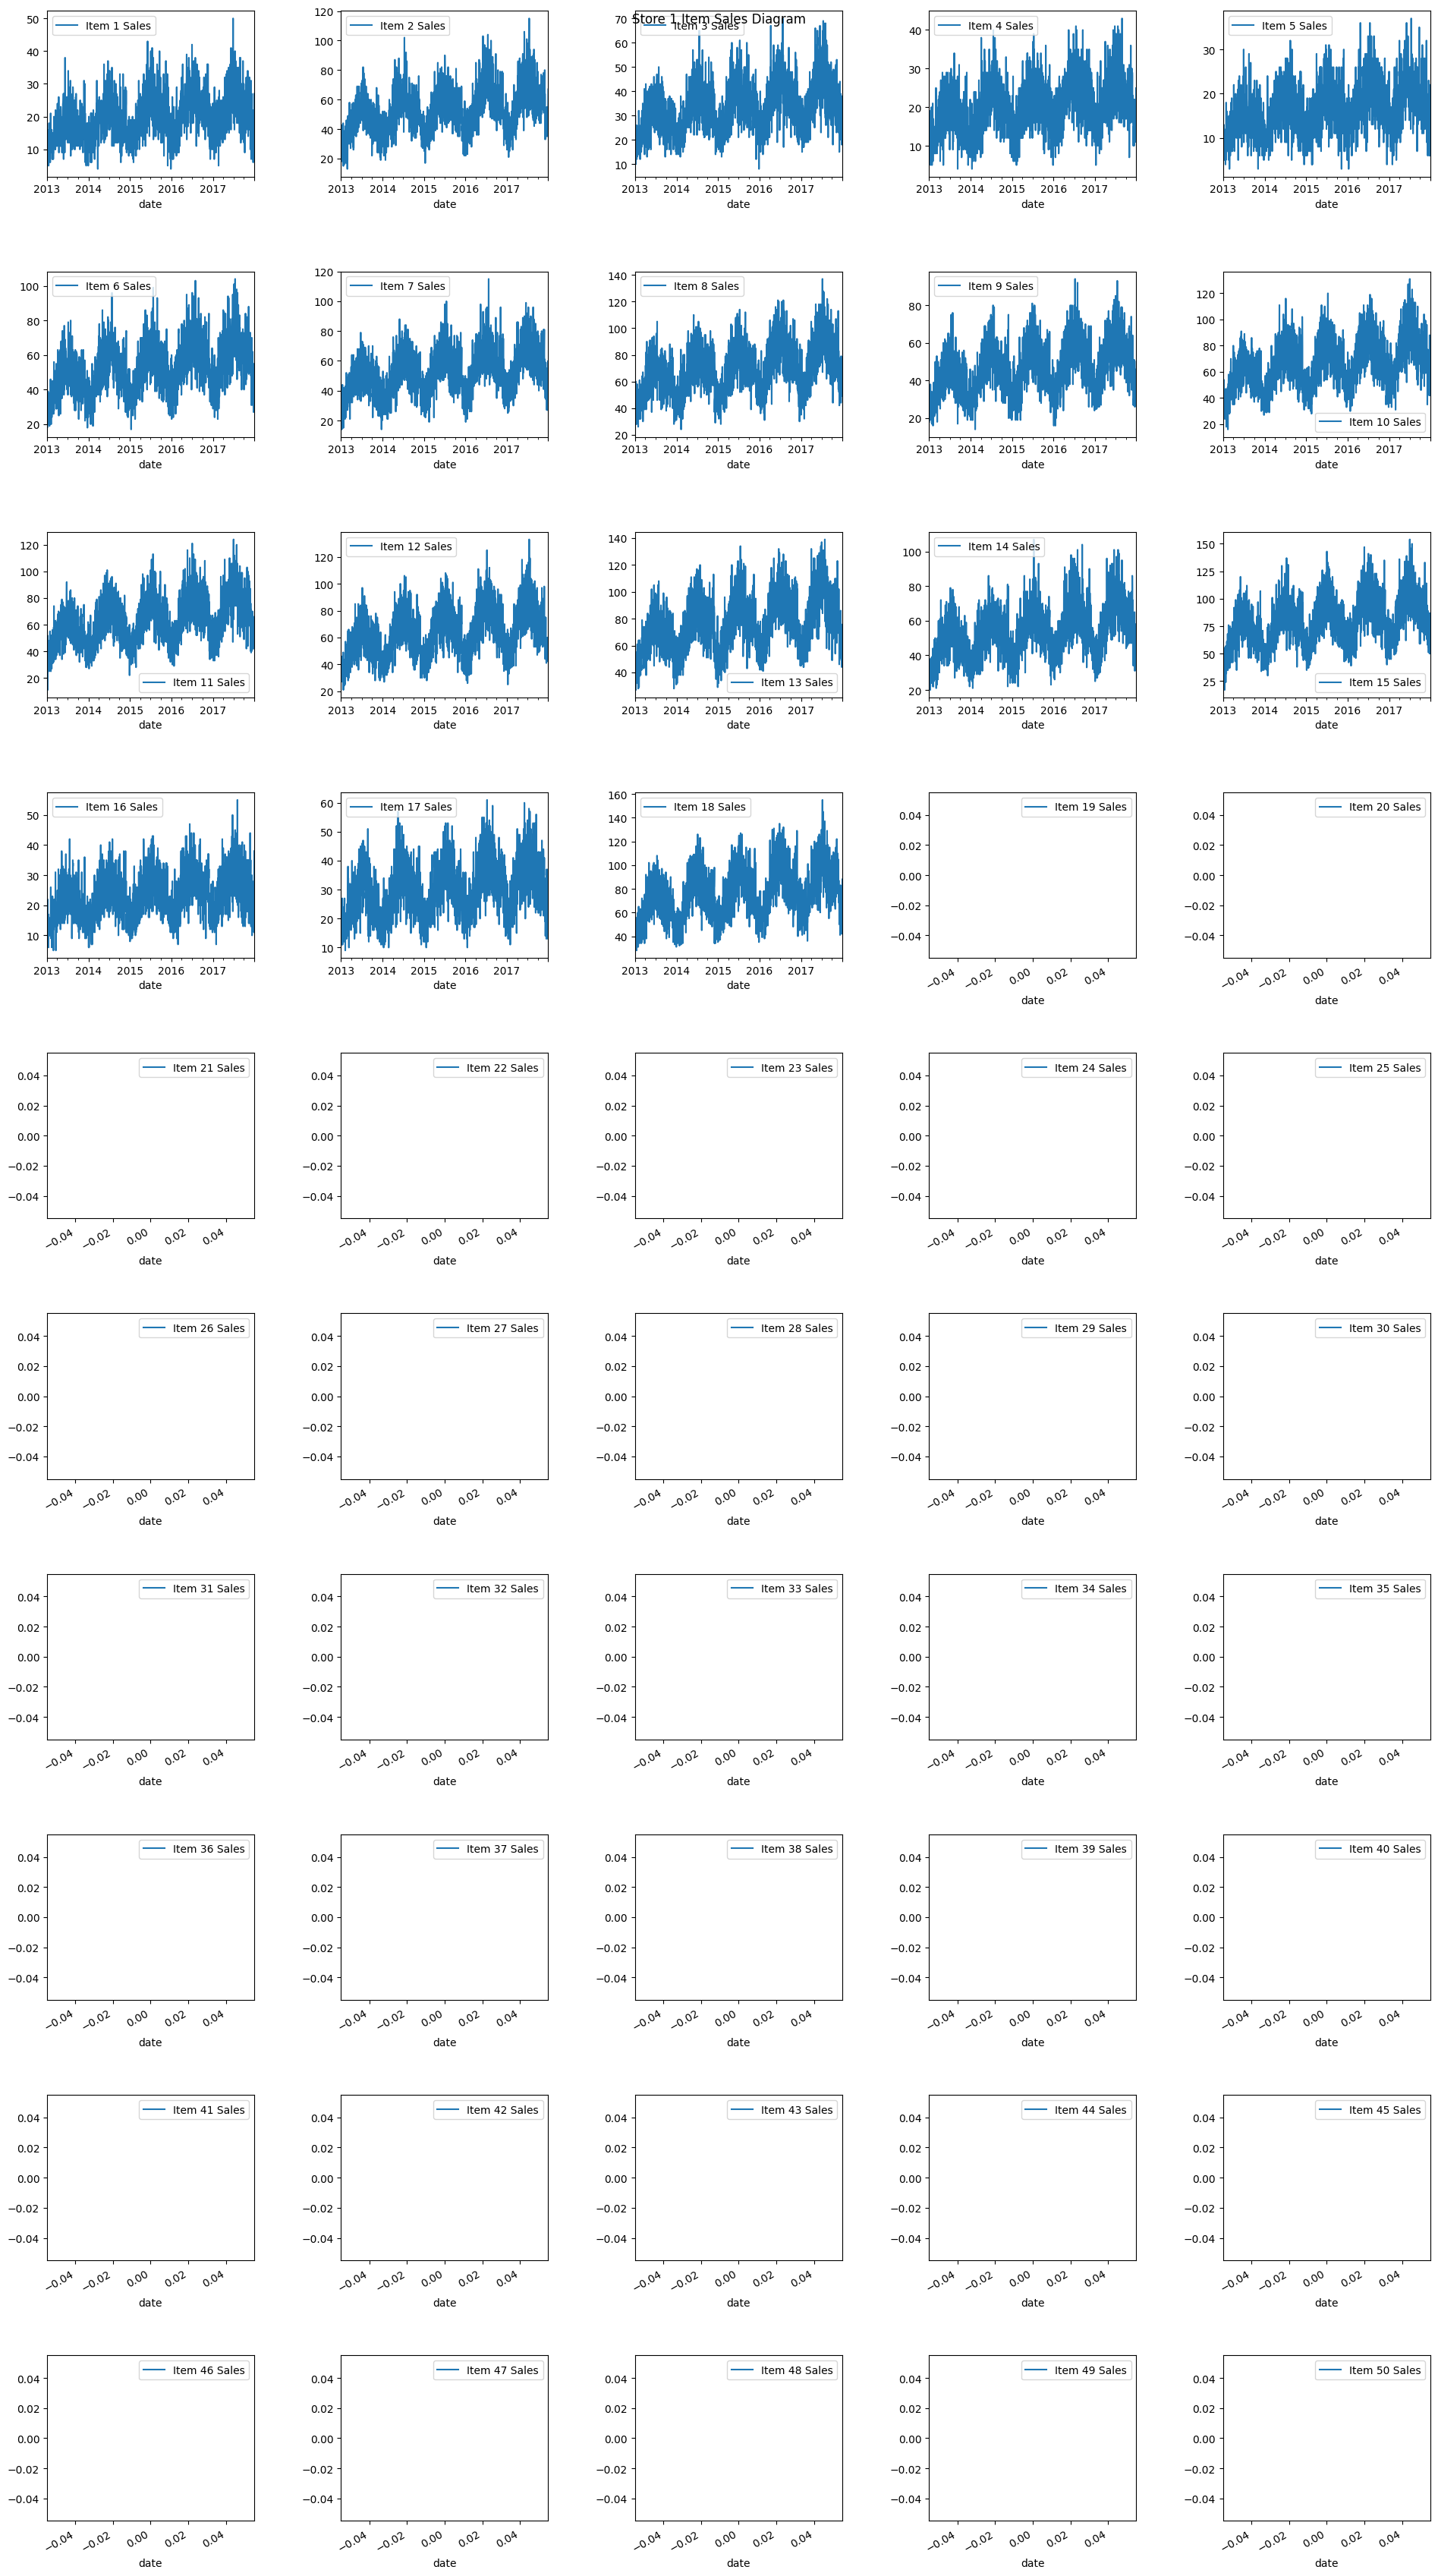

In [17]:
store = 1
sub = train[train.store == store].set_index("date")
fig, axes = plt.subplots(10, 5, figsize=(20, 35))
for i in range(1,51):
    if i < 6:
        sub[sub.item == i].sales.plot(ax=axes[0, i-1], legend=True, label = "Item "+str(i)+" Sales")
    if i >= 6 and i<11:
        sub[sub.item == i].sales.plot(ax=axes[1, i - 6], legend=True, label = "Item "+str(i)+" Sales")
    if i >= 11 and i<16:
        sub[sub.item == i].sales.plot(ax=axes[2, i - 11], legend=True, label = "Item "+str(i)+" Sales")    
    if i >= 16 and i<21:
        sub[sub.item == i].sales.plot(ax=axes[3, i - 16], legend=True, label = "Item "+str(i)+" Sales")    
    if i >= 21 and i<26:
        sub[sub.item == i].sales.plot(ax=axes[4, i - 21], legend=True, label = "Item "+str(i)+" Sales")  
    if i >= 26 and i<31:
        sub[sub.item == i].sales.plot(ax=axes[5, i - 26], legend=True, label = "Item "+str(i)+" Sales")    
    if i >= 31 and i<36:
        sub[sub.item == i].sales.plot(ax=axes[6, i - 31], legend=True, label = "Item "+str(i)+" Sales")    
    if i >= 36 and i<41:
        sub[sub.item == i].sales.plot(ax=axes[7, i - 36], legend=True, label = "Item "+str(i)+" Sales")    
    if i >= 41 and i<46:
        sub[sub.item == i].sales.plot(ax=axes[8, i - 41], legend=True, label = "Item "+str(i)+" Sales") 
    if i >= 46 and i<51:
        sub[sub.item == i].sales.plot(ax=axes[9, i - 46], legend=True, label = "Item "+str(i)+" Sales") 
plt.tight_layout(pad=4.5)
plt.suptitle("Store 1 Item Sales Diagram");

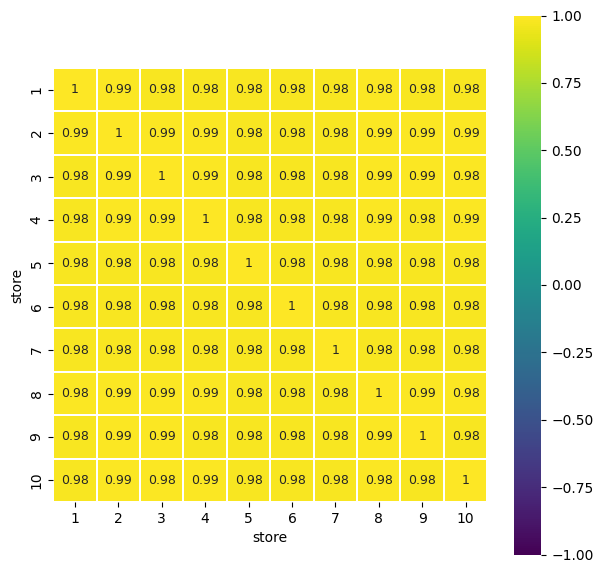

In [18]:
storesales = train.groupby(["date", "store"]).sales.sum().reset_index().set_index("date")
corr =  pd.pivot_table(storesales, values = "sales", columns="store", index="date").corr(method = "spearman")
plt.figure(figsize = (7,7))
sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.5)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 9}, square=True);

In [19]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

In [20]:
data.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)
data.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0


In [21]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

data = lag_features(data, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

In [22]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


data = roll_mean_features(data, [365, 546, 730])

In [23]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe


alphas = [0.99, 0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

data = ewm_features(data, alphas, lags)
data.tail()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_730,sales_ewm_alpha_099_lag_91,sales_ewm_alpha_099_lag_98,sales_ewm_alpha_099_lag_105,sales_ewm_alpha_099_lag_112,sales_ewm_alpha_099_lag_180,sales_ewm_alpha_099_lag_270,sales_ewm_alpha_099_lag_365,sales_ewm_alpha_099_lag_546,sales_ewm_alpha_099_lag_728,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,2018,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44999,2018-03-31,10,50,NaN,44999.0,3,31,90,13,5,2018,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
data = pd.get_dummies(data, columns=['day_of_week', 'month'])

In [25]:
data['sales'] = np.log1p(data["sales"].values)

In [26]:
train = data.loc[(data["date"] < "2017-01-01"), :]
val = data.loc[(data["date"] >= "2017-01-01") & (data["date"] < "2017-04-01"), :]
cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

In [27]:
Y_train = train['sales']
X_train = train[cols]
Y_val = val['sales']
X_val = val[cols]
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((261536,), (261536, 94), (16110,), (16110, 94))

In [28]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val
def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [29]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 2000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [30]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=100)
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
smape(np.expm1(y_pred_val), np.expm1(Y_val))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.296518 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.172439	training's SMAPE: 17.5873	valid_1's l1: 0.170797	valid_1's SMAPE: 17.4626
[200]	training's l1: 0.140692	training's SMAPE: 14.4178	valid_1's l1: 0.14405	valid_1's SMAPE: 14.7855
[300]	training's l1: 0.134536	training's SMAPE: 13.8026	valid_1's l1: 0.139315	valid_1's SMAPE: 14.3107
[400]	training's l1: 0.132072	training's SMAPE: 13.5571	valid_1's l1: 0.137672	valid_1's SMAPE: 14.1465
[500]	training's l1: 0.130634	training's SMAPE: 13.4137	valid_1's l1: 0.136265	valid_1's SMAPE: 14.0054
[600]	training's l1: 0.129651	training's SMAPE: 13.3154	valid_1's l1: 0.135247	valid_1's SMAPE: 13.9031
[700]	training's l1: 0.128925	training's SMAPE: 13.2426	valid_1's l1: 0.134467	valid_1's SMAPE: 13.8246
[800]	training's l1: 0.128367	training's SMAPE

13.546552652081274

In [31]:
train = data.loc[~data.sales.isna()]
Y_train = train['sales']
X_train = train[cols]
test = data.loc[data.sales.isna()]
X_test = test[cols]

In [32]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

# LightGBM dataset
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)
test_preds = model.predict(X_test, num_iteration=model.best_iteration)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.907068 seconds.
You can set `force_col_wise=true` to remove the overhead.


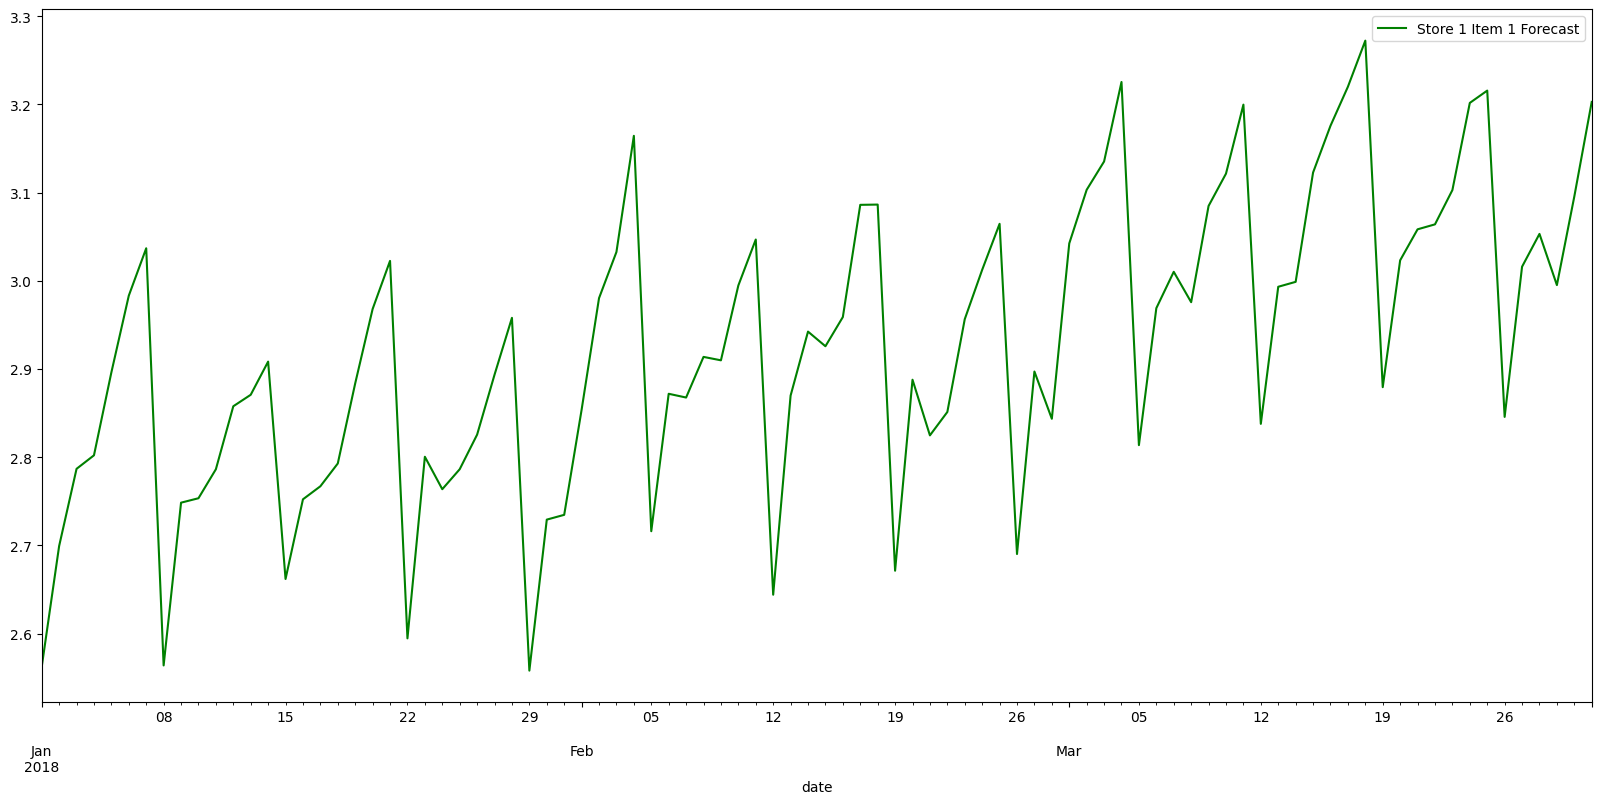

In [33]:
forecast = pd.DataFrame({"date":test["date"],
                        "store":test["store"],
                        "item":test["item"],
                        "sales":test_preds
                        })

forecast[(forecast.store == 1) & (forecast.item == 1)].set_index("date").sales.plot(color = "green",
                                                                                    figsize = (20,9),
                                                                                    legend=True, label = "Store 1 Item 1 Forecast");

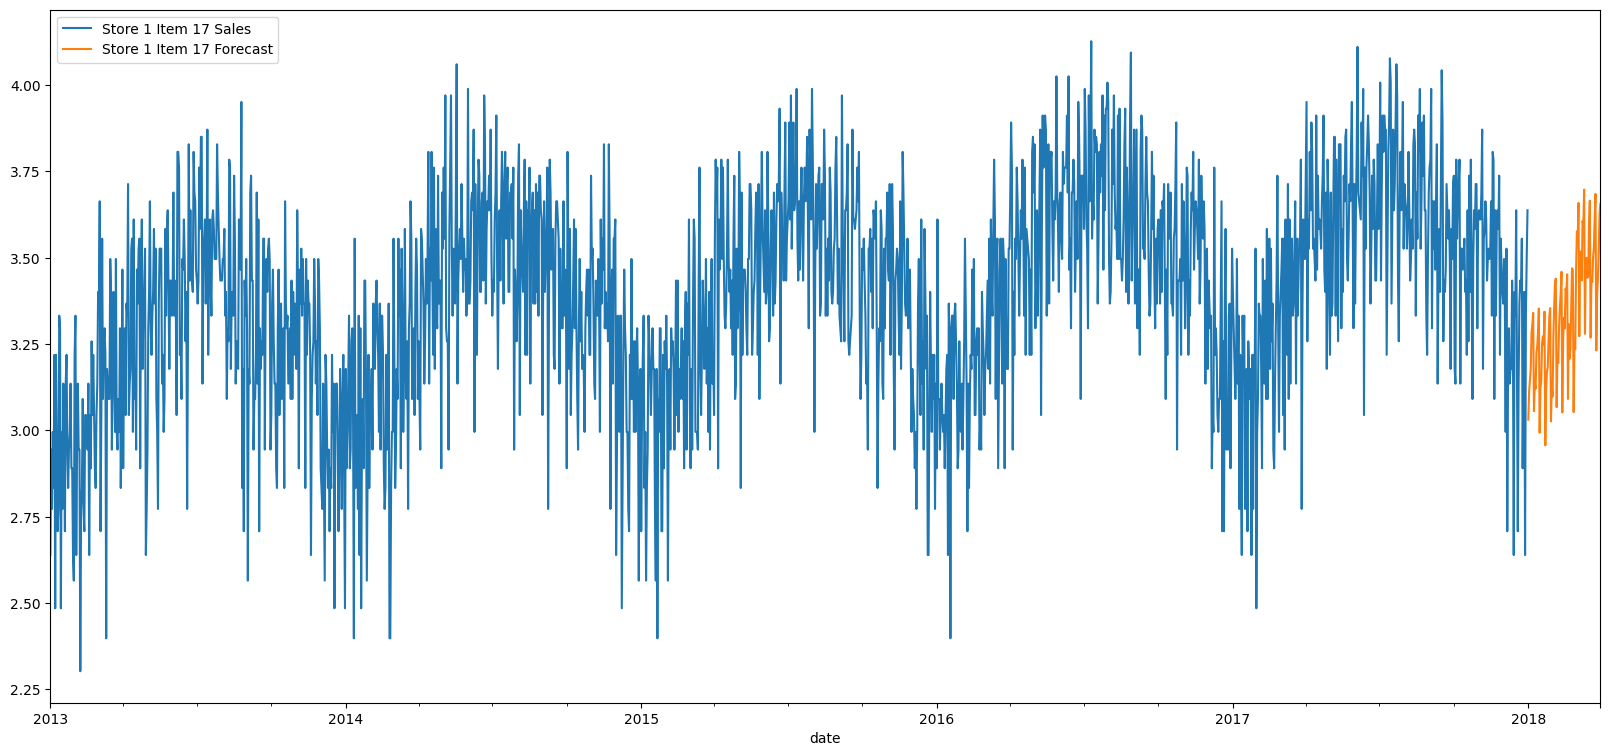

In [34]:
train[(train.store == 1) & (train.item == 17)].set_index("date").sales.plot(figsize = (20,9),legend=True, label = "Store 1 Item 17 Sales")
forecast[(forecast.store == 1) & (forecast.item == 17)].set_index("date").sales.plot(legend=True, label = "Store 1 Item 17 Forecast");

In [35]:
data.shape

(371871, 98)

In [38]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

def lgbm_smape(y_true, y_pred):
    smape_val = smape(y_true, y_pred)
    return 'SMAPE', smape_val, False

In [39]:
first_model = lgb.LGBMRegressor(random_state=384).fit(X_train, Y_train, eval_metric= lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])
print("TRAIN SMAPE:", smape(Y_train, first_model.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, first_model.predict(X_val)))

TRAIN SMAPE: 3.542973536184608
VALID SMAPE: 3.7990319145663256


In [40]:
def plot_lgb_importances(model, plot=False, num=10):
    from matplotlib import pyplot as plt
    import seaborn as sns
    gain = model.booster_.feature_importance(importance_type='gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name_,
                             'split': model.booster_.feature_importance(importance_type='split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
        return feat_imp

feature_imp_df = plot_lgb_importances(first_model, num=50)

                        feature  split       gain
20          sales_roll_mean_730    185  64.804238
15                sales_lag_364    385  15.220088
19          sales_roll_mean_546    202   6.458421
72   sales_ewm_alpha_05_lag_365    122   3.541543
3                   day_of_year    322   1.281837
75                day_of_week_0    104   1.236751
74   sales_ewm_alpha_05_lag_728     94   1.234564
21   sales_ewm_alpha_099_lag_91     18   1.203905
5                       is_wknd     83   0.848456
93                     month_12     95   0.686431
4                  week_of_year     86   0.394773
65   sales_ewm_alpha_07_lag_728     17   0.389445
1                          item    182   0.315290
22   sales_ewm_alpha_099_lag_98      7   0.293795
63   sales_ewm_alpha_07_lag_365     17   0.265148
71   sales_ewm_alpha_05_lag_270     52   0.259811
56   sales_ewm_alpha_08_lag_728     12   0.172694
18          sales_roll_mean_365    130   0.148835
88                      month_7     43   0.097408


In [41]:
feature_imp_df.shape, feature_imp_df[feature_imp_df.gain > 0].shape, feature_imp_df[feature_imp_df.gain > 0.57].shape

((94, 3), (92, 3), (10, 3))

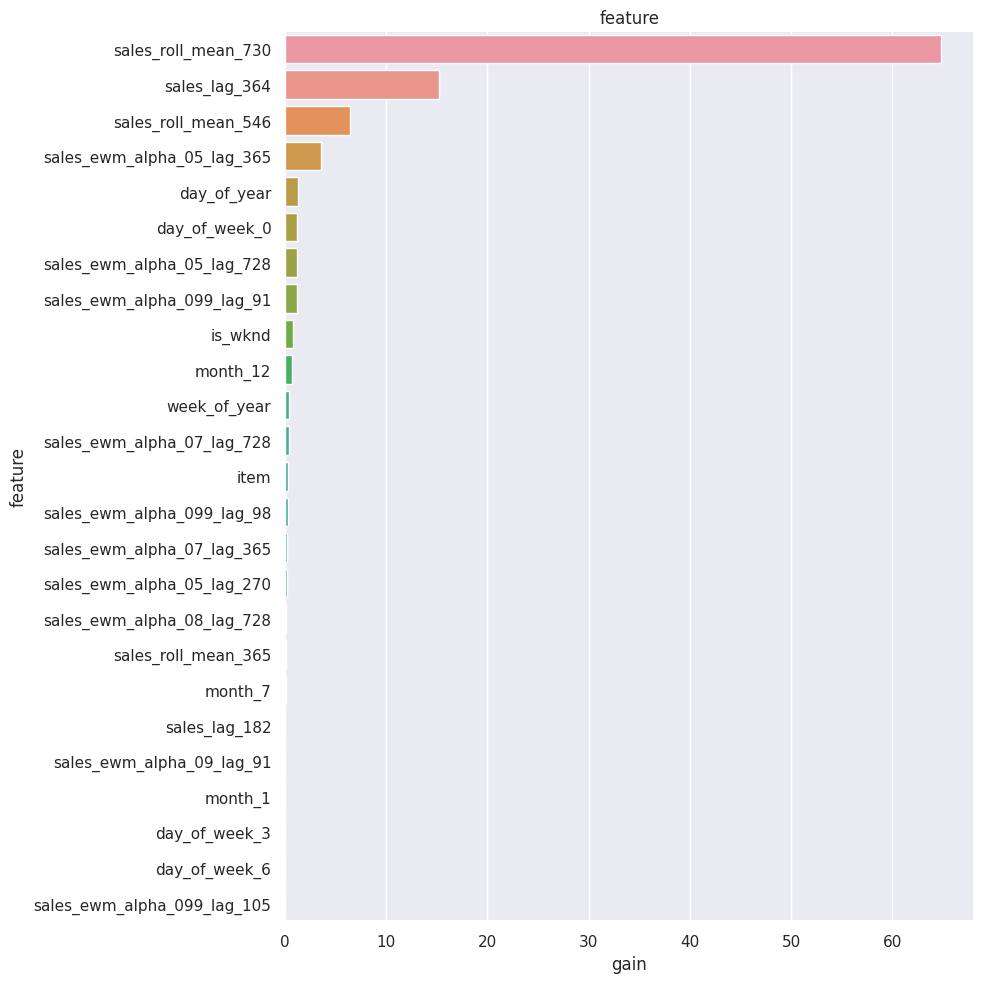

In [42]:
plot_lgb_importances(first_model, plot=True, num=30)